In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# NN Implementation for Regression 
Refs: [PyTorch-Example](https://github.com/pytorch/examples/blob/master/regression)

In [2]:
rng = np.random.RandomState(515)
N = 200

X = np.sort(rng.rand(N, 1), axis=0) * 4 * np.pi
y = np.sin(X).ravel() + 0.1 * rng.randn(N)
X_ticks = np.arange(0, 1, 0.01)[:, None] * 4 * np.pi
y_real = np.sin(X_ticks).ravel()

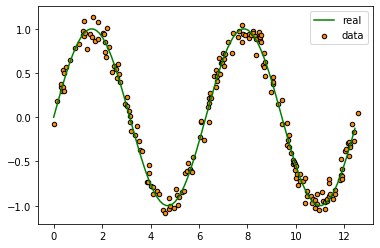

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X.ravel(), y, s=20, c='darkorange', edgecolors='k', label='data')
ax.plot(X_ticks.ravel(), y_real, c='g', label='real')
ax.legend()

In [4]:
from sklearn.preprocessing import StandardScaler
# Standardize input data, only fit on train_set
scaler = StandardScaler()
scaler.fit(X)
print(scaler.mean_, scaler.var_)

X = scaler.transform(X)

[6.82554297] [13.2843321]


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc_layer1 = nn.Linear(1, 10)
        self.fc_layer2 = nn.Linear(10, 10)
        self.fc_layer3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = F.relu(self.fc_layer1(x))
        x = F.tanh(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

model = Model()

In [6]:
X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))

loss_func = nn.SmoothL1Loss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adadelta(model.parameters())
# optimizer = optim.Adam(model.parameters())

print_every = 5000
print_loss_total = 0

batch_size = 5
iter_i = 0
for epoch in range(1000):
    for i in range(N//batch_size):
        optimizer.zero_grad()
        
        pred_y = model(X[i*batch_size:(i+1)*batch_size])
        loss = loss_func(pred_y, y[i*batch_size:(i+1)*batch_size].view(-1, 1))
        loss.backward()
        optimizer.step()
        
        print_loss_total += loss.item()
        
        iter_i += 1
        if iter_i % print_every == 0:
            print('Iter: %d, Loss: %.6f' % (iter_i, print_loss_total/print_every))
            print_loss_total = 0

Iter: 5000, Loss: 0.070095
Iter: 10000, Loss: 0.033078
Iter: 15000, Loss: 0.017381
Iter: 20000, Loss: 0.012446
Iter: 25000, Loss: 0.010123
Iter: 30000, Loss: 0.008406
Iter: 35000, Loss: 0.006991
Iter: 40000, Loss: 0.005975


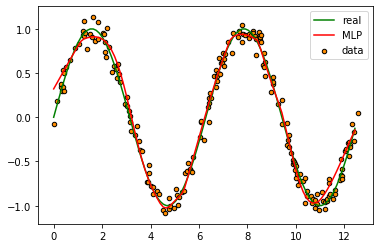

In [7]:
X_ticks = scaler.transform(X_ticks)
X_ticks = torch.from_numpy(X_ticks.astype(np.float32))
y_pred = model(X_ticks)

X = X.numpy()
y = y.numpy()
X_ticks = X_ticks.numpy()
y_pred = y_pred.detach().numpy()

X = scaler.inverse_transform(X)
X_ticks = scaler.inverse_transform(X_ticks)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X.ravel(), y, s=20, c='darkorange', edgecolors='k', label='data')
ax.plot(X_ticks.ravel(), y_real, c='g', label='real')
ax.plot(X_ticks.ravel(), y_pred.flatten(), c='r', label='MLP')
ax.legend()

# Linear SVM

## Linear SVM Loss with soft margin
$$
\min_{w,b}{\frac{1}{2}\|\omega\|^2 + C \cdot \sum_{i=1}^{m}{\max (0,1-y_i(\omega^Tx_i+b))}}
$$

## Other Surrogate Loss
### Hinge Loss
$$
\mathrm{HingeLoss} (z) = \max (0, 1-z)
$$
### Exponential Loss
$$
\mathrm{ExpLoss} (z) = e^{-z}
$$
### Logistic Loss
$$
\mathrm{LogLoss}(z) = \log (1+e^{-z})
$$

## nn.MultiMarginLoss
$$
\mathrm{Loss}(x, y) = \frac{\sum_{i \neq y}{\max (0, (margin-x[y]+x[i]))^p}}{x.size(0)}
$$  

NOTE: the objective is improving the difference between $x[y]$ and $x[i]$, i.e., improving $x[y]-x[i]$, which is equal to reducing $x[i]-x[y]$.  

In [8]:
class LinearSVM(nn.Module):
    def __init__(self, x_dim, n_types):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(x_dim, n_types)
        
    def forward(self, x):
        return self.fc(x)
    
svm = LinearSVM(2, 2)

In [9]:
N = 1000
x = np.random.randn(N, 2).astype(np.float32)
y = np.zeros(N, dtype=np.int64)
x[N//2:] += 1
y[N//2:] = 1
x = torch.from_numpy(x)
y = torch.from_numpy(y)

svm(x)

tensor([[ 0.3649,  0.1678],
        [ 0.1184, -0.1216],
        [ 0.1880,  0.4251],
        ...,
        [ 0.3062,  0.1371],
        [-0.2423,  1.2927],
        [-0.6093, -0.3367]], grad_fn=<AddmmBackward>)

In [10]:
loss_func = nn.MultiMarginLoss()
optimizer = optim.LBFGS(svm.parameters())

def closure():
    optimizer.zero_grad()
    # MUST put the predicted varibale at the first argument
    loss = loss_func(svm(x), y)
    loss.backward()
    return loss

# Performs a single optimization step
optimizer.step(closure=closure)

list(svm.parameters())

[Parameter containing:
 tensor([[-0.8095, -0.5453],
         [ 0.0530,  0.2408]], requires_grad=True),
 Parameter containing:
 tensor([ 0.7914, -0.0952], requires_grad=True)]

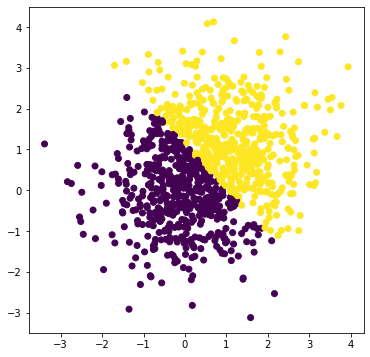

In [11]:
y_pred = np.argmax(svm(x).detach().numpy(), axis=1)
x = x.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], c=y_pred)